# Action1_LSTM_(30,30)_meijimu_stock

美吉姆股票价格预测

本题采用LSTM预测30天的股票价格，时间步入出为(30-->30),多对多

多对多例图(3-->2)

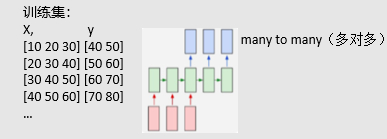

In [100]:
# 使用LSTM预测沪市指数
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from pandas import DataFrame
from pandas import concat
from itertools import chain
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签

In [2]:
# 转化为可以用于监督学习的数据
def get_train_set(data_set, timesteps_in, timesteps_out=1):
    train_data_set = np.array(data_set)
    reframed_train_data_set = np.array(series_to_supervised(train_data_set, timesteps_in, timesteps_out).values)
    print(reframed_train_data_set)
    print(reframed_train_data_set.shape)
    train_x, train_y = reframed_train_data_set[:, :-timesteps_out], reframed_train_data_set[:, -timesteps_out:]
    # 将数据集重构为符合LSTM要求的数据格式,即 [样本数，时间步，特征]
    train_x = train_x.reshape((train_x.shape[0], timesteps_in, 1))
    return train_x, train_y

In [43]:
agg.values

array([[23.98, 23.1 , 22.66, 24.25, 23.6 , 24.48],
       [23.1 , 22.66, 24.25, 23.6 , 24.48, 25.47],
       [22.66, 24.25, 23.6 , 24.48, 25.47, 25.3 ],
       ...,
       [ 6.5 ,  6.53,  6.73,  6.99,  6.95,  6.93],
       [ 6.53,  6.73,  6.99,  6.95,  6.93,  7.02],
       [ 6.73,  6.99,  6.95,  6.93,  7.02,  7.  ]])

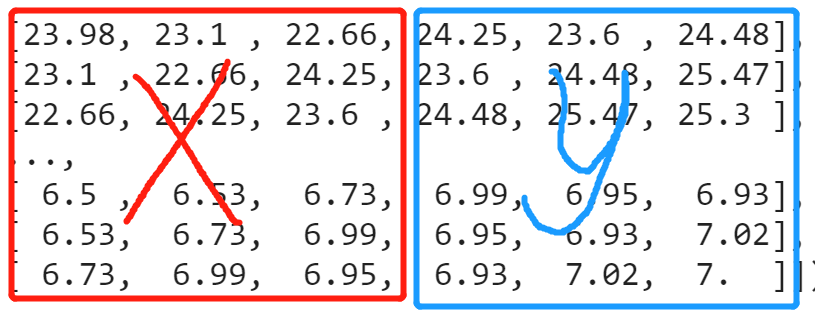

In [49]:
# train_x
agg.values[:,:-3]

array([[23.98, 23.1 , 22.66],
       [23.1 , 22.66, 24.25],
       [22.66, 24.25, 23.6 ],
       ...,
       [ 6.5 ,  6.53,  6.73],
       [ 6.53,  6.73,  6.99],
       [ 6.73,  6.99,  6.95]])

In [17]:
np.array(data_set).shape

(1963,)

In [3]:
# 通过入步和出步，主要利用pd.shift()进行错步填充，以此来分x_train,y_label
"""
将时间序列数据转换为适用于监督学习的数据
给定输入、输出序列的长度
data: 观察序列
n_in: 观测数据input(X)的步长，范围[1, len(data)], 默认为1
n_out: 观测数据output(y)的步长， 范围为[0, len(data)-1], 默认为1
dropnan: 是否删除NaN行
返回值：适用于监督学习的 DataFrame
"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i)) # DataFrame列往下错位一格，并用Nan填充第i行，丢失掉之前的最后i行
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # 拼接到一起
    global agg
    agg = concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [31]:
# 去掉nan之前
agg

,var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2)
0,NaN,NaN,NaN,23.98,23.10,22.66
1,NaN,NaN,23.98,23.10,22.66,24.25
2,NaN,23.98,23.10,22.66,24.25,23.60
3,23.98,23.10,22.66,24.25,23.60,24.48
4,23.10,22.66,24.25,23.60,24.48,25.47
...,...,...,...,...,...,...
2191,6.50,6.53,6.73,6.99,6.95,6.93
2192,6.53,6.73,6.99,6.95,6.93,7.02
2193,6.73,6.99,6.95,6.93,7.02,7.00
2194,6.99,6.95,6.93,7.02,7.00,NaN


In [34]:
# 去掉nan后，也就是去掉所有的包含nan的行，这里时间步设置(3,3)，上三列，下两列
agg

,var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2)
3,23.98,23.10,22.66,24.25,23.60,24.48
4,23.10,22.66,24.25,23.60,24.48,25.47
5,22.66,24.25,23.60,24.48,25.47,25.30
6,24.25,23.60,24.48,25.47,25.30,26.11
7,23.60,24.48,25.47,25.30,26.11,26.25
...,...,...,...,...,...,...
2189,6.64,6.66,6.50,6.53,6.73,6.99
2190,6.66,6.50,6.53,6.73,6.99,6.95
2191,6.50,6.53,6.73,6.99,6.95,6.93
2192,6.53,6.73,6.99,6.95,6.93,7.02


时间入步为3的name取值

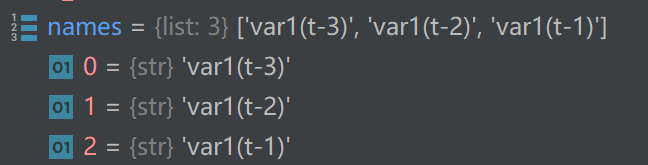

In [122]:
# 使用LSTM进行预测
def lstm_model(source_data_set, train_x, label_y, input_epochs, input_batch_size, timesteps_out):
    model = Sequential()
    
    # 第一层, 隐藏层神经元节点个数为128, 返回整个序列
    model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(train_x.shape[1], train_x.shape[2])))
    # 第二层，隐藏层神经元节点个数为128, 只返回序列最后一个输出
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))
    # 第三层 因为是回归问题所以使用linear
    model.add(Dense(timesteps_out, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # LSTM训练 input_epochs次数, verbose = 2 为每个epoch输出一行记录, =1为输出进度条记录, =0 不在标准输出流输出日志信息
    res = model.fit(train_x, label_y, epochs=input_epochs, batch_size=input_batch_size, verbose=2, shuffle=False)

    # 模型预测
    train_predict = model.predict(train_x)
    #test_data_list = list(chain(*test_data))
    train_predict_list = list(chain(*train_predict))

    plt.plot(res.history['loss'], label='train')
    plt.show()
    print(model.summary())
    plot_img(source_data_set, train_predict)

In [119]:
# 呈现原始数据，训练结果，验证结果，预测结果
def plot_img(source_data_set, train_predict):
    plt.figure(figsize=(24, 8))
#     # 原始数据蓝色
#     plt.plot(source_data_set[:, -1], c='b')  # 原始数据有括号，取每一行的括号内数
    # 训练集原始数据,shift错位提取数据后、drapna后的数据
    plt.plot(agg.iloc[:,0].values[30:],c='g',label='实际数据') # 使用了初始数据dropna后减少59行数据后的
    # 预测数据，红色
    plt.plot([x for x in train_predict[:,-1]], c='r',label='预测数据')# 这里做了修改，预测结果取预测最后一列
    plt.legend()
    plt.show()

In [123]:
# 设置观测数据input(X)的步长（时间步），epochs，batch_size
timesteps_in = 30
timesteps_out = 30
epochs = 200
batch_size = 100

In [33]:
data = pd.read_csv('./002621.csv')
# data_set = data[::-1][['开盘价']].values.astype('float64')

In [34]:
data[::-1]

,日期,股票代码,名称,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,总市值,流通市值
2195,2011/9/29,'002621,N三垒,24.08,25.15,22.88,23.98,24.00,0.08,0.3333,57.5282,11522900,2.806628e+08,2408000000,482322400
2194,2011/9/30,'002621,大连三垒,22.69,23.80,22.05,23.10,24.08,-1.39,-5.7724,26.7312,5354251,1.215095e+08,2269000000,454480700
2193,2011/10/10,'002621,大连三垒,23.60,24.18,22.36,22.66,22.69,0.91,4.0106,22.7764,4562109,1.065325e+08,2360000000,472708000
2192,2011/10/11,'002621,大连三垒,24.13,25.85,23.70,24.25,23.60,0.53,2.2458,34.9752,7005537,1.723708e+08,2413000000,483323900
2191,2011/10/12,'002621,大连三垒,24.80,25.15,22.55,23.60,24.13,0.67,2.7766,30.1920,6047448,1.458584e+08,2480000000,496744000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2020/10/12,'002621,美吉姆,6.96,6.99,6.72,6.99,6.86,0.1,1.4577,0.5032,4071930,2.812961e+07,5753573554,5632501229
3,2020/10/13,'002621,美吉姆,6.95,6.96,6.84,6.95,6.96,-0.01,-0.1437,0.2279,1844460,1.275408e+07,5745306926,5624408555
2,2020/10/14,'002621,美吉姆,6.85,7.16,6.84,6.93,6.95,-0.1,-1.4388,0.4038,3267859,2.279647e+07,5662640639,5543481813
1,2020/10/15,'002621,美吉姆,7.04,7.23,6.90,7.02,6.85,0.19,2.7737,0.7743,6265798,4.435304e+07,5819706584,5697242623


In [35]:
data_set = data[::-1][['开盘价']].replace(0,np.nan)
data_set.dropna(inplace=True)
data_set = data_set.values.astype('float64')
data_set.shape

(1963, 1)

In [75]:
data_set.shape

(1963, 1)

In [110]:
# 转化为可以用于监督学习的数据
train_x, label_y = get_train_set(data_set, timesteps_in=timesteps_in, timesteps_out=timesteps_out)

[[23.98 23.1  22.66 ... 21.33 21.   19.67]
 [23.1  22.66 24.25 ... 21.   19.67 19.7 ]
 [22.66 24.25 23.6  ... 19.67 19.7  19.68]
 ...
 [ 7.64  7.75  7.4  ...  6.99  6.95  6.93]
 [ 7.75  7.4   7.22 ...  6.95  6.93  7.02]
 [ 7.4   7.22  7.34 ...  6.93  7.02  7.  ]]
(1904, 60)


In [61]:
train_x.shape,label_y.shape

((1904, 30, 1), (1904, 30))

In [92]:
agg.iloc[:,0].values

array([23.98, 23.1 , 22.66, ...,  7.64,  7.75,  7.4 ])

Epoch 1/200
20/20 - 3s - loss: 242.6095
Epoch 2/200
20/20 - 3s - loss: 159.6451
Epoch 3/200
20/20 - 3s - loss: 105.8613
Epoch 4/200
20/20 - 3s - loss: 73.7354
Epoch 5/200
20/20 - 3s - loss: 54.9583
Epoch 6/200
20/20 - 3s - loss: 44.2658
Epoch 7/200
20/20 - 3s - loss: 38.7165
Epoch 8/200
20/20 - 3s - loss: 35.7378
Epoch 9/200
20/20 - 3s - loss: 33.6893
Epoch 10/200
20/20 - 3s - loss: 32.8759
Epoch 11/200
20/20 - 3s - loss: 31.8194
Epoch 12/200
20/20 - 4s - loss: 31.9232
Epoch 13/200
20/20 - 3s - loss: 31.6072
Epoch 14/200
20/20 - 3s - loss: 31.9212
Epoch 15/200
20/20 - 3s - loss: 31.6710
Epoch 16/200
20/20 - 3s - loss: 31.5106
Epoch 17/200
20/20 - 4s - loss: 31.2176
Epoch 18/200
20/20 - 4s - loss: 31.1673
Epoch 19/200
20/20 - 4s - loss: 31.6369
Epoch 20/200
20/20 - 4s - loss: 31.5939
Epoch 21/200
20/20 - 4s - loss: 31.7360
Epoch 22/200
20/20 - 4s - loss: 31.5841
Epoch 23/200
20/20 - 4s - loss: 31.7041
Epoch 24/200
20/20 - 3s - loss: 31.5349
Epoch 25/200
20/20 - 3s - loss: 31.3065
Epoch 

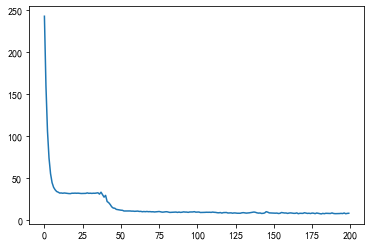

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 30, 128)           66560     
_________________________________________________________________
lstm_43 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 30)                3870      
Total params: 202,014
Trainable params: 202,014
Non-trainable params: 0
_________________________________________________________________
None


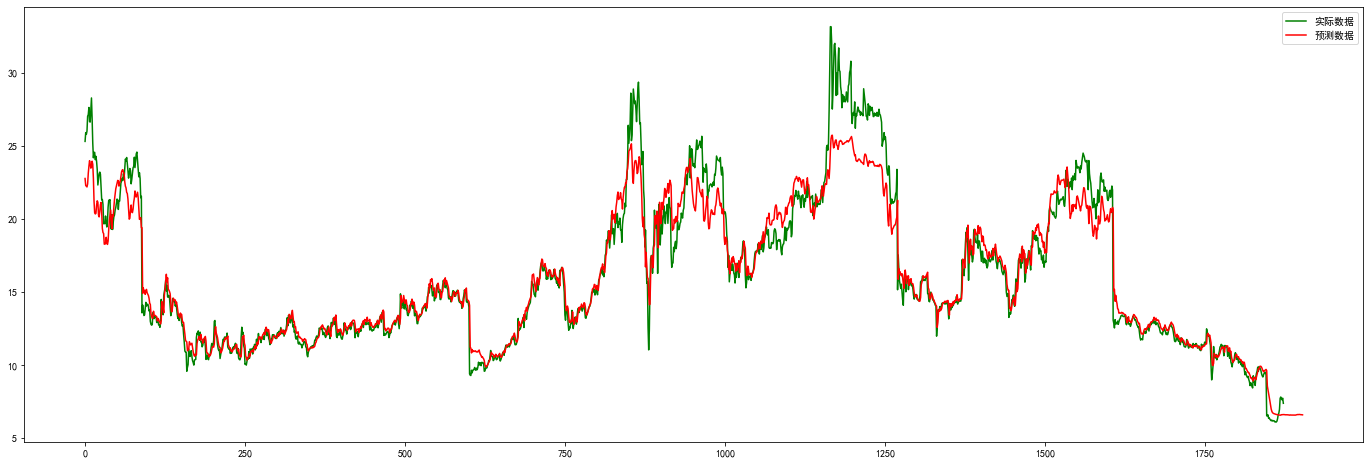

In [124]:
# 使用LSTM进行训练、预测
lstm_model(data_set, train_x, label_y, epochs, batch_size, timesteps_out=timesteps_out)